In [87]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [88]:
# Configurações de conexão com o banco de dados
db_host = 'localhost'
db_user = 'root'
db_password = 'erp2024'
db_name = 'erp_db'

# Função para conectar ao MySQL e extrair dados
def extract_data_to_csv():
    # Conecta ao MySQL
    conn = pymysql.connect(host=db_host, user=db_user, password=db_password, database=db_name)

    try:
        # Consulta SQL revisada para extrair dados
        query = """
            SELECT oi.id as order_item_id, oi.order_id, oi.item_id, oi.quantity, 
                   i.category_id, i.stock_quantity, o.date_ordered
            FROM order_items oi
            JOIN items i ON oi.item_id = i.id
            JOIN orders o ON oi.order_id = o.id
        """

        # Executa a consulta e carrega os resultados em um DataFrame do pandas
        df = pd.read_sql(query, conn)

        # Preenchimento de dados ausentes com a média
        df.fillna(df.mean(), inplace=True)

        # Salva o DataFrame em um arquivo CSV
        df.to_csv('dados_erp.csv', index=False)

        print("Dados extraídos, pré-processados e salvos com sucesso em 'dados_erp.csv'.")

    except Exception as e:
        print(f"Erro ao extrair dados: {str(e)}")

    finally:
        # Fecha a conexão com o banco de dados
        conn.close()

In [89]:
# Chamada da função para extrair dados e salvar em CSV
extract_data_to_csv()

Dados extraídos, pré-processados e salvos com sucesso em 'dados_erp.csv'.


In [90]:
def exploracao_dados(file_path):
    # Carregar o arquivo CSV para um DataFrame
    df = pd.read_csv(file_path)

    # Visualizar as primeiras linhas para entender a estrutura dos dados
    print(df.head())

    # Verificar informações gerais do DataFrame
    print(df.info())

    # Estatísticas descritivas para variáveis numéricas
    print(df.describe())

    # Contagem de valores únicos em cada coluna
    print(df.nunique())

    # Exemplo de visualização: Distribuição da quantidade de itens por categoria
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='quantity', bins=20, kde=True)
    plt.title('Distribuição da Quantidade de Itens')
    plt.xlabel('Quantidade')
    plt.ylabel('Frequência')
    plt.show()

    # Converter colunas de data para datetime, se necessário
    if 'order_date' in df.columns:
        df['order_date'] = pd.to_datetime(df['order_date'])

    # Excluir colunas não numéricas para calcular a matriz de correlação
    numeric_cols = df.select_dtypes(include=['number']).columns
    df_numeric = df[numeric_cols]

    # Matriz de correlação
    correlation_matrix = df_numeric.corr()
    print(correlation_matrix)

    # Visualização da matriz de correlação
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
    plt.title('Matriz de Correlação')
    plt.show()

    # Exemplo: Boxplot da quantidade por categoria
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='category_id', y='quantity')
    plt.title('Quantidade de Itens por Categoria')
    plt.xlabel('Categoria')
    plt.ylabel('Quantidade')
    plt.show()

   order_item_id  order_id  item_id  quantity  category_id  stock_quantity  \
0              1         1        1         2            3             100   
1              2         2        2         3            2             200   
2              3         3        3         1            1              50   
3              4         4        4         1            3              50   
4              5         5        5         2            6             100   

  date_ordered  
0   2024-06-06  
1   2024-06-07  
2   2024-06-08  
3   2024-06-09  
4   2024-06-10  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_item_id   13 non-null     int64 
 1   order_id        13 non-null     int64 
 2   item_id         13 non-null     int64 
 3   quantity        13 non-null     int64 
 4   category_id     13 non-null     int64 
 5   stock_quantity

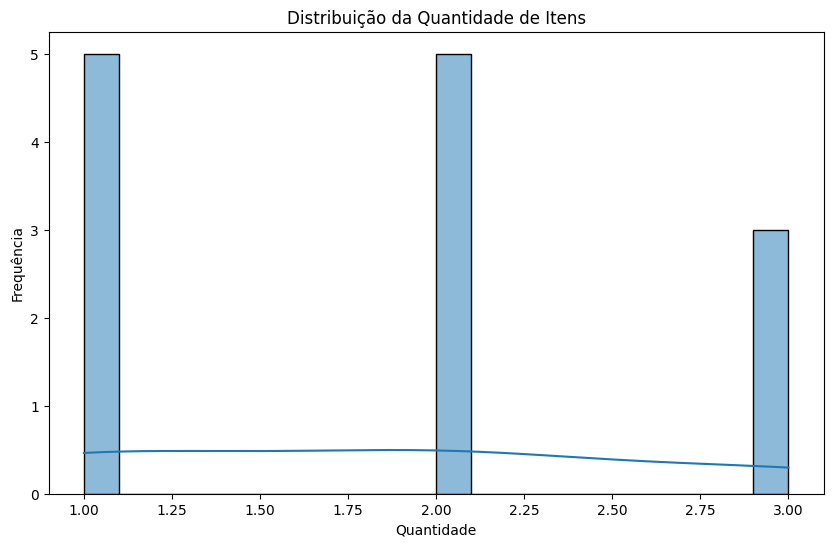

                order_item_id  order_id   item_id  quantity  category_id  \
order_item_id        1.000000  1.000000  1.000000 -0.053452     0.407410   
order_id             1.000000  1.000000  1.000000 -0.053452     0.407410   
item_id              1.000000  1.000000  1.000000 -0.053452     0.407410   
quantity            -0.053452 -0.053452 -0.053452  1.000000    -0.237701   
category_id          0.407410  0.407410  0.407410 -0.237701     1.000000   
stock_quantity      -0.001289 -0.001289 -0.001289  0.801783    -0.074118   

                stock_quantity  
order_item_id        -0.001289  
order_id             -0.001289  
item_id              -0.001289  
quantity              0.801783  
category_id          -0.074118  
stock_quantity        1.000000  


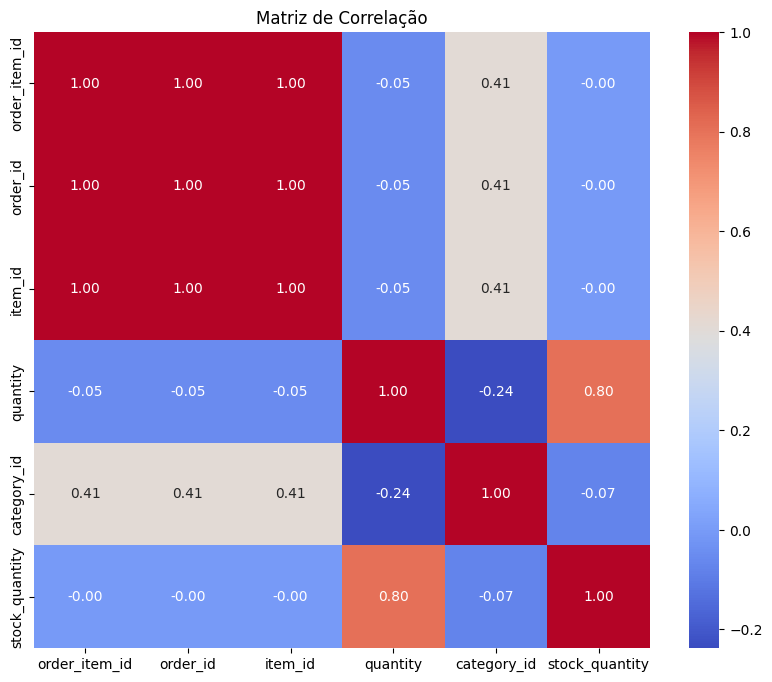

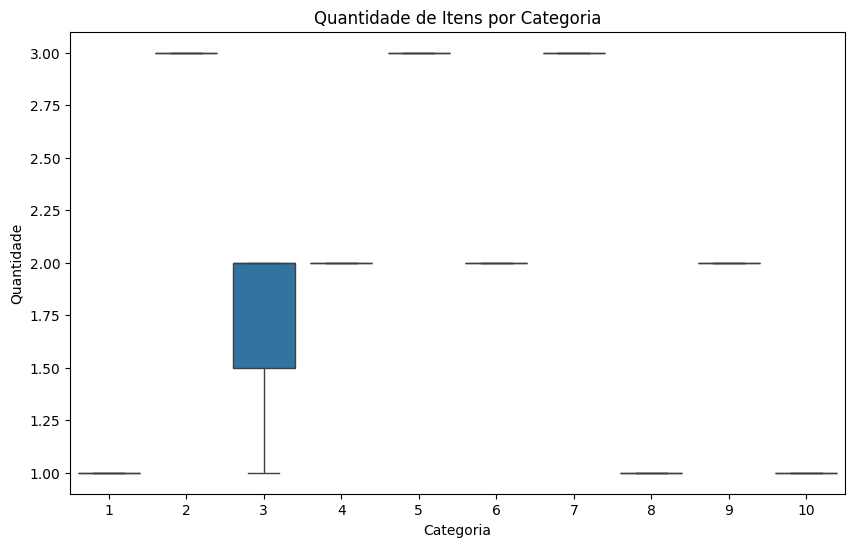

In [91]:
# Caminho para o arquivo CSV com os dados extraídos
file_path = 'dados_erp.csv'

# Chamar a função de exploração de dados
exploracao_dados(file_path)

In [92]:
def preparacao_dados(file_path):
    # Carregar os dados do CSV
    df = pd.read_csv(file_path)

    # Converter a coluna de data para datetime
    df['date_ordered'] = pd.to_datetime(df['date_ordered'])

    # Criar novas features baseadas na data
    df['year'] = df['date_ordered'].dt.year
    df['month'] = df['date_ordered'].dt.month
    df['day'] = df['date_ordered'].dt.day
    df['dayofweek'] = df['date_ordered'].dt.dayofweek

    # Codificar variáveis categóricas
    labelencoder = LabelEncoder()
    df['category_id'] = labelencoder.fit_transform(df['category_id'])

    # Separar os recursos (features) e o alvo (target)
    X = df.drop(columns=['stock_quantity', 'date_ordered', 'order_id', 'item_id'])
    y = df['stock_quantity']

    return X, y

In [93]:
def treino_avaliacao_xgboost(X_train, X_test, y_train, y_test):
    # Criar o modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Avaliar o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE) - XGBoost: {mse}')

    # Calcular a eficiência em relação ao XGBoost
    efficiency = (1 - mse / mse_xgboost) * 100
    print(f'Eficiência em relação ao XGBoost: {efficiency:.2f}%')

    # Visualizar as previsões vs valores reais
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Previsões vs Valores Reais - XGBoost')
    plt.show()

    return mse

In [94]:
def treino_avaliacao_random_forest(X_train, X_test, y_train, y_test):
    # Criar o modelo Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Avaliar o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE) - Random Forest: {mse}')

    # Calcular a eficiência em relação ao XGBoost
    efficiency = (1 - mse / mse_xgboost) * 100
    print(f'Eficiência em relação ao XGBoost: {efficiency:.2f}%')

    # Visualizar as previsões vs valores reais
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Previsões vs Valores Reais - Random Forest')
    plt.show()

    return mse

In [95]:
def treino_avaliacao_regressao_linear(X_train, X_test, y_train, y_test):
    # Criar o modelo de Regressão Linear
    model = LinearRegression()

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Avaliar o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE) - Regressão Linear: {mse}')

    # Calcular a eficiência em relação ao XGBoost
    efficiency = (1 - mse / mse_xgboost) * 100
    print(f'Eficiência em relação ao XGBoost: {efficiency:.2f}%')

    # Visualizar as previsões vs valores reais
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Previsões vs Valores Reais - Regressão Linear')
    plt.show()

    return mse

In [96]:
if __name__ == "__main__":
    # Preparação dos dados
    X, y = preparacao_dados(file_path)

    # Divisão dos dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Treino e avaliação do modelo XGBoost
    model_xgboost = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model_xgboost.fit(X_train, y_train)
    y_pred_xgboost = model_xgboost.predict(X_test)
    mse_xgboost = mean_squared_error(y_test, y_pred_xgboost)
    print(f'Mean Squared Error (MSE) - XGBoost: {mse_xgboost}')

    # Treino e avaliação do modelo Random Forest
    model_random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    model_random_forest.fit(X_train, y_train)
    y_pred_random_forest = model_random_forest.predict(X_test)
    mse_random_forest = mean_squared_error(y_test, y_pred_random_forest)
    print(f'Mean Squared Error (MSE) - Random Forest: {mse_random_forest}')

    # Treino e avaliação do modelo de Regressão Linear
    model_regressao_linear = LinearRegression()
    model_regressao_linear.fit(X_train, y_train)
    y_pred_regressao_linear = model_regressao_linear.predict(X_test)
    mse_regressao_linear = mean_squared_error(y_test, y_pred_regressao_linear)
    print(f'Mean Squared Error (MSE) - Regressão Linear: {mse_regressao_linear}')

    # Calcular a eficiência em relação ao XGBoost para cada modelo
    efficiency_random_forest = (1 - mse_random_forest / mse_xgboost) * 100
    efficiency_regressao_linear = (1 - mse_regressao_linear / mse_xgboost) * 100

    # Corrigindo para garantir que a eficiência não seja negativa
    if efficiency_random_forest < 0:
        efficiency_random_forest = 0
    if efficiency_regressao_linear < 0:
        efficiency_regressao_linear = 0

    # Tabela de Resultados Comparativos
    results = {
        'Modelo': ['XGBoost', 'Random Forest', 'Regressão Linear'],
        'Mean Squared Error (MSE)': [mse_xgboost, mse_random_forest, mse_regressao_linear],
        'Eficiência em relação ao XGBoost (%)': [100.0, efficiency_random_forest, efficiency_regressao_linear],
    }

    results_df = pd.DataFrame(results)
    print("\nTabela de Resultados Comparativos:")
    print(results_df)


Mean Squared Error (MSE) - XGBoost: 700.9151842372763
Mean Squared Error (MSE) - Random Forest: 917.6133333333332
Mean Squared Error (MSE) - Regressão Linear: 5300.197415848032

Tabela de Resultados Comparativos:
             Modelo  Mean Squared Error (MSE)  \
0           XGBoost                700.915184   
1     Random Forest                917.613333   
2  Regressão Linear               5300.197416   

   Eficiência em relação ao XGBoost (%)  
0                                 100.0  
1                                   0.0  
2                                   0.0  
